In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import  RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.decomposition import PCA
from RFBDoSBC.GetAndPrepareData import *
from RFBDoSBC.modelPreparation import *
from RFBDoSBC.modelEvaluation import *
from RFBDoSBC.plotData import *
from RFBDoSBC.utility import *


In [2]:

rad_mom_gen = res_pT_iterator()
text_results = {}

In [77]:
rad, ptm = next(rad_mom_gen)
msg("Analyzing jets with R=%1.1f and p_T hardmin=%d"%(rad, ptm))


JEB: Analyzing jets with R=0.3 and p_T hardmin=10


In [78]:
best_params = loadBestParameters(rad, ptm)
best_params_lowpt = loadBestParameters(rad, ptm, True)
rfModel = [makeRandomForest(best_params) for _ in range(10)]
rfModelLowpt = [makeRandomForest(best_params_lowpt) for _ in range(10)]

batch_num = 0
feat_imp = {}

In [79]:
print(best_params_lowpt)
print(best_params)

{'n_estimators': 100, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 100, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.1, 'max_features': 'auto', 'max_leaf_nodes': 1000, 'min_impurity_decrease': 0.0, 'class_weight': {1: 1, 2: 1, 3: 4}, 'max_samples': 0.9, 'oob_score': True, 'random_state': 42, 'n_jobs': -1}
{'n_estimators': 100, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 100, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.1, 'max_features': 'auto', 'max_leaf_nodes': 1000, 'min_impurity_decrease': 0.0, 'max_samples': 0.9, 'oob_score': True, 'random_state': 42, 'n_jobs': -1}


In [80]:
dataGen = DataPipelineBatch(f"Analysis_Code/Generator Output/merged-ML-output-LOWSTATS-Rparam-{rad}-pThardmin-{ptm}.0.csv", ptm, True, False)




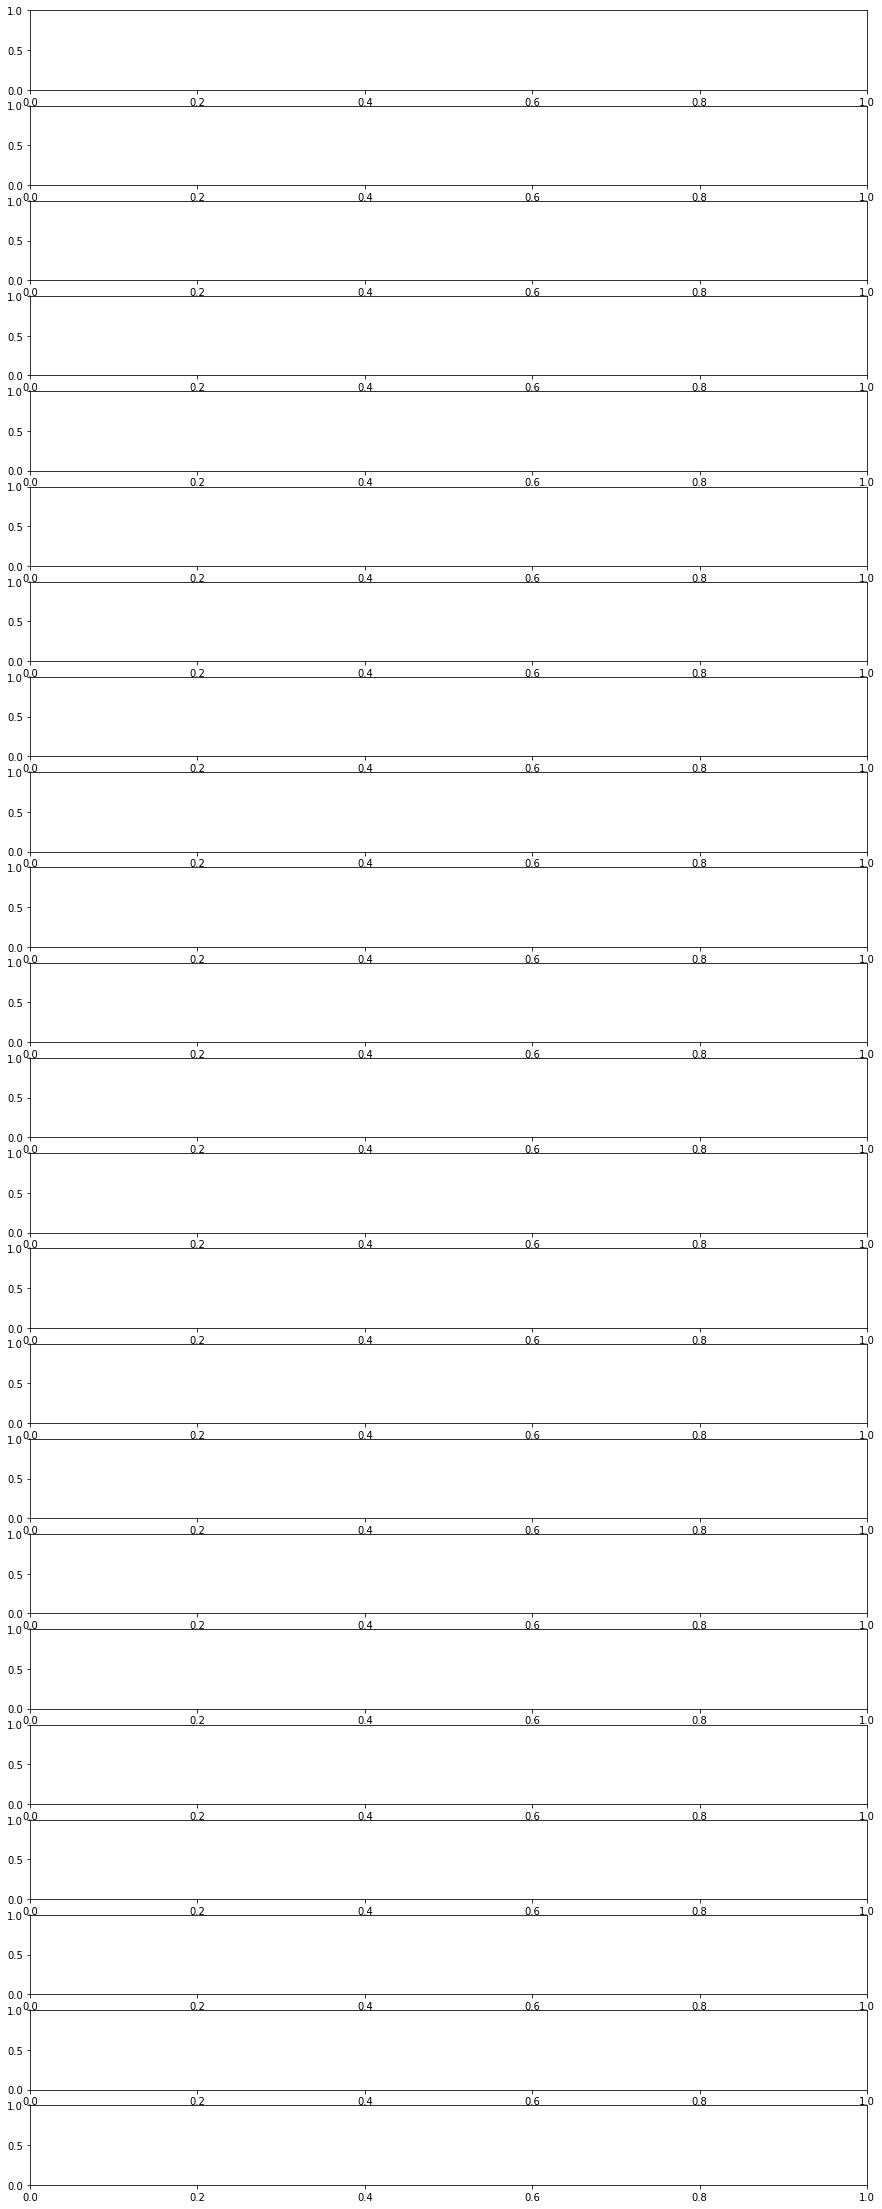

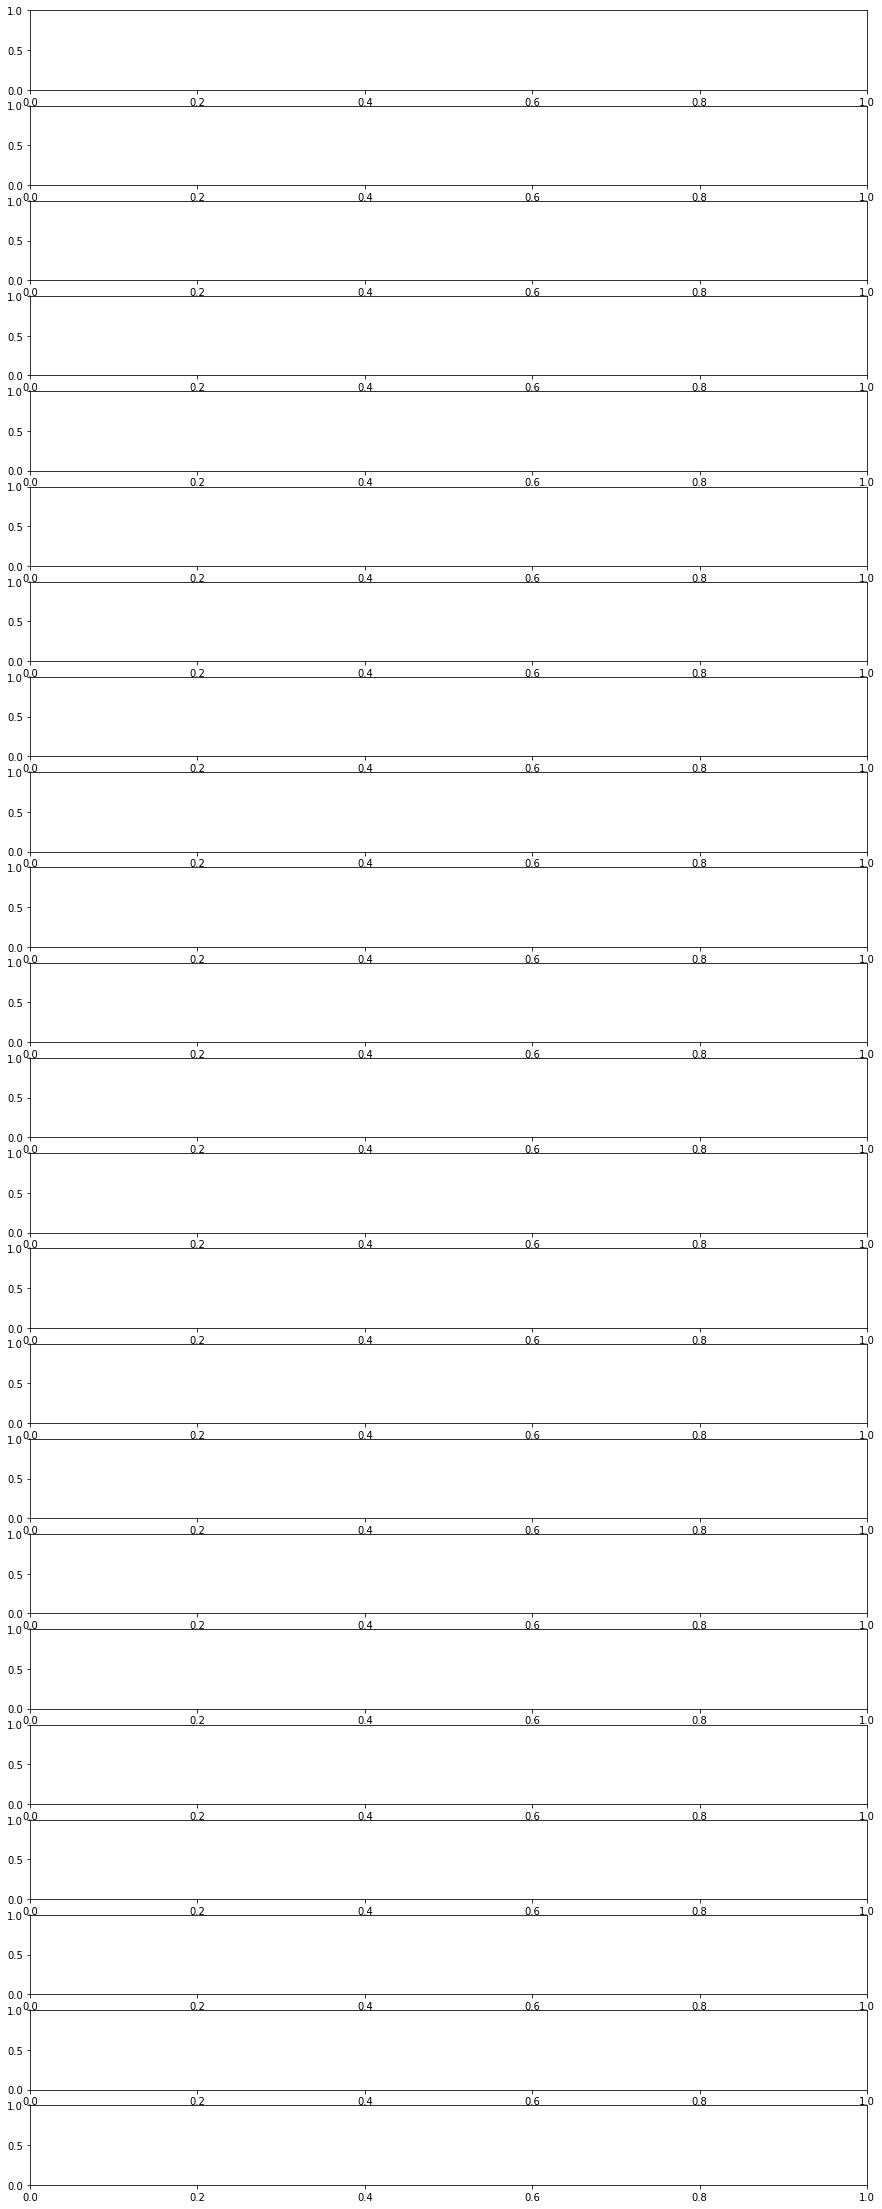

In [81]:
fig, ax = plt.subplots(8+15, 1, figsize=(15,40));
fig1, ax1 = plt.subplots(8+15, 1, figsize=(15,40));


In [82]:
text_results[f'R{rad}pt{ptm}'] = {}


In [83]:

do_plotting = False
low_pt = False

start_time = time.time()

while batch_num<12:
    try:
        print(f"Doing batch_num {batch_num}")
        
        train, test = next(dataGen)
        if low_pt:
            trainLowpt = train.loc[train['p_T']<(100+(ptm/10-1)*20)]

        #if(batch_num==1):
        #    sns.pairplot(data=train, hue='Label_Name')

        i=0

        X, Y = split_feat_label(train)
        if low_pt:
            XLowpt, YLowpt = split_feat_label(trainLowpt)

        # Test PCA

        pca = PCA()

        pca.fit(X)

        print(f"PCA variances: {pca.explained_variance_ratio_} \n Components: {pca.components_}")
        text_results[f'R{rad}pt{ptm}']['pca'] = [(pca.explained_variance_ratio_[i], dict(zip(X.columns,pca.components_[i]))) for i in range(len(X.columns))]

        if low_pt:
            pca_low = PCA()

            pca_low.fit(XLowpt)

            print(f"PCA variances: {pca_low.explained_variance_ratio_} \n Components: {pca_low.components_}")
            text_results[f'R{rad}pt{ptm}']['pca_low'] = [(pca_low.explained_variance_ratio_[i], dict(zip(X.columns,pca_low.components_[i]))) for i in range(len(X.columns))]

        rfModel[batch_num] = doRandomForestFit(X, Y, rfModel[batch_num], batch_num)
        if low_pt:
            rfModelLowpt[batch_num] = doRandomForestFit(XLowpt, YLowpt, rfModelLowpt[batch_num], batch_num)

        if do_plotting:
            print("Plotting...")
            if not low_pt:
                for feat in train.columns:

                    if feat in ['p_T', 'Label_Name']:
                        continue
                    sns.scatterplot(data=train, x='p_T',y=feat, hue='Label_Name',hue_order=["Fake", "< Hard Scattering p_T", ">= Hard Scattering p_T"], alpha=0.005, ax=ax[i], s=1)
                    ax[i].legend([],[])
                    i+=1

            else:
                for feat in train.columns:
                    if feat in ['p_T', 'Label_Name']:
                        continue
                    sns.scatterplot(data=trainLowpt, x='p_T',y=feat, hue='Label_Name',hue_order=["Fake", "< Hard Scattering p_T", ">= Hard Scattering p_T"], alpha=0.005, ax=ax1[i], s=1)
                    ax1[i].legend([],[])
                    i+=1

        batch_num+=1
    except StopIteration:
        print(f"No more data in batch num: {batch_num}, trimming forest.")
        rfModel = rfModel[:batch_num]
        if low_pt:
            rfModelLowpt = rfModelLowpt[:batch_num]
        break
train_and_plot_time = time.time()-start_time
if do_plotting:
    print("Saving...")
    if not low_pt:
        fig.legend(["Fake", "< Hard Scattering p_T", ">= Hard Scattering p_T"])
        fig.savefig(f'all_jet_features_R{rad}_pt{ptm}.png', format='png', dpi=600)
    else:
        fig1.legend(["Fake", "< Hard Scattering p_T", ">= Hard Scattering p_T"])
        fig1.savefig(f"lowp_T_jet_features_R{rad}_pt{ptm}.png", format='png', dpi=600)

save_time = time.time()-train_and_plot_time

print(f"It took {train_and_plot_time}s to train and plot. It took {save_time}s to save")

Doing batch_num 0
PCA variances: [9.88248401e-01 6.19896531e-03 5.28171516e-03 2.70918332e-04] 
 Components: [[ 4.1609593e-02  7.9311728e-03  3.0262923e-02  9.9864405e-01]
 [-9.6545118e-01 -2.4942286e-01 -6.1240200e-02  4.4063285e-02]
 [-6.0472608e-02 -1.5753951e-02  9.9766421e-01 -2.7588457e-02]
 [-2.5003079e-01  9.6823394e-01  2.0911358e-04  2.7219057e-03]]
JEB: Fitting to data for batch 0.
Doing batch_num 1
PCA variances: [9.88017916e-01 6.31774862e-03 5.38824977e-03 2.76085153e-04] 
 Components: [[ 0.0417169   0.00799072  0.03040716  0.99863464]
 [-0.9672891  -0.24934396 -0.01828339  0.04295935]
 [-0.0187042  -0.00582     0.9993701  -0.02960163]
 [-0.2495236   0.9683647   0.00104761  0.00264311]]
JEB: Fitting to data for batch 1.
Doing batch_num 2
PCA variances: [9.88317537e-01 6.15701238e-03 5.25708415e-03 2.68366022e-04] 
 Components: [[ 4.1247949e-02  7.8505278e-03  2.9935215e-02  9.9866951e-01]
 [-9.6751928e-01 -2.4862288e-01 -1.7114222e-02  4.2428762e-02]
 [-1.7646510e-02 -5.1

In [84]:
print(X.head())

             Area  Angularity  Mean-p_T    p_T_1
1606771  0.212497    0.184426  0.491290  1.73454
1607326  0.251588    0.208175  0.489356  2.47130
1604180  0.166389    0.177896  0.479033  2.17444
1609254  0.286670    0.203059  0.505902  3.96288
1610642  0.075176    0.133258  0.539759  1.72700


In [85]:
train, test = DataPipeline(f"Analysis_Code/Generator Output/merged-ML-output-LOWSTATS-Rparam-{rad}-pThardmin-{ptm}.0.csv", ptm, 200000000, True)
if low_pt:
    trainLowpt = train.loc[train['p_T']<100]

X, Y = split_feat_label(train)

if low_pt:
    XLowpt, YLowpt = split_feat_label(trainLowpt)


In [86]:
oracle = doOracleFit(X, rfModel, rad, ptm)
if low_pt:
    oracleLowpt = doOracleFit(XLowpt, rfModelLowpt, rad, ptm, True)

JEB: Initializing Oracle and fitting to rfModel's predictions
(5, 1412550) [[2 2 2 ... 1 2 2]
 [2 1 2 ... 1 2 2]
 [2 2 2 ... 1 2 2]
 [2 1 2 ... 2 2 2]
 [2 1 2 ... 2 2 2]]
(1412550,) 0          2
1          1
2          2
3          1
4          2
          ..
1412545    1
1412546    2
1412547    1
1412548    2
1412549    2
Length: 1412550, dtype: int64
[1 2]


In [87]:
from sklearn.metrics import accuracy_score

Xtest, Ytest = split_feat_label(test)
oracle_test_predictions = oracle.predict(Xtest)
oracle_acc = accuracy_score(Ytest, oracle_test_predictions)
print(f"Oracle accuracy: {oracle_acc}")
text_results[f'R{rad}pt{ptm}']['oracle_acc'] = oracle_acc

ave_rf_acc=0

for i,rf in enumerate(rfModel):
    rf_predictions = rf.predict(Xtest)
    rf_acc = accuracy_score(Ytest, rf_predictions)
    ave_rf_acc+=rf_acc
    print(f"Random Forest accuracy, model {i}: {rf_acc}")
ave_rf_acc/=(i+1)

text_results[f'R{rad}pt{ptm}']['ave_rf_acc'] = ave_rf_acc



if low_pt:
    testLowpt = test.loc[test['p_T']<100]
    XtestLowpt, YtestLowpt = split_feat_label(testLowpt)
    oracleLowpt_test_predictions = oracleLowpt.predict(XtestLowpt)
    oracle_acc_low = accuracy_score(YtestLowpt, oracleLowpt_test_predictions)
    print(f"Oracle Low p_T accuracy: {oracle_acc_low}")
    text_results[f'R{rad}pt{ptm}']['oracle_acc_low'] = oracle_acc_low

    ave_rf_acc_low = 0

    for i,rf in enumerate(rfModelLowpt):
        rf_predictions = rf.predict(XtestLowpt)
        rf_acc_low = accuracy_score(YtestLowpt, rf_predictions)
        ave_rf_acc_low+=rf_acc_low
        print(f"Random Forest accuracy, model {i}: {rf_acc_low}")
    ave_rf_acc_low/=(i+1)

    text_results[f'R{rad}pt{ptm}']['ave_rf_acc_low'] = ave_rf_acc_low




Oracle accuracy: 0.6205194569828226
Random Forest accuracy, model 0: 0.6214426088384711
Random Forest accuracy, model 1: 0.6215445519881746
Random Forest accuracy, model 2: 0.6209895281731221
Random Forest accuracy, model 3: 0.6205534380327238
Random Forest accuracy, model 4: 0.6205562697868822


JEB: Computing feature importances and other model statistics.
JEB: Feature rankings:
1. Area (0.639532)
2. Angularity (0.271135)
3. p_T_1 (0.088971)
4. Mean-p_T (0.000362)
JEB: Plotting feature importances.
JEB: Plot distribution of importances.
JEB: Computing performance metrics
predictions_train=[array([2, 2, 1, ..., 1, 2, 2]), array([2, 2, 2, ..., 1, 1, 2])]
population_rates_train=[0.7043318979550814, 0.5383492230738293]
predictions_test=[array([2, 2, 2, ..., 2, 2, 1]), array([2, 2, 1, ..., 2, 2, 1])]
population_rates_test=[0.7051017516013831, 0.5379340002716039]
JEB: Computing feature importances and other model statistics.
JEB: Feature rankings:
1. Area (0.648011)
2. Angularity (0.275776)
3. p_T_1 (0.075735)
4. Mean-p_T (0.000479)
JEB: Plotting feature importances.
JEB: Plot distribution of importances.
JEB: Computing performance metrics
predictions_train=[array([2, 2, 1, ..., 1, 2, 2]), array([1, 2, 2, ..., 1, 1, 2])]
population_rates_train=[0.6990391175962651, 0.543978609746840

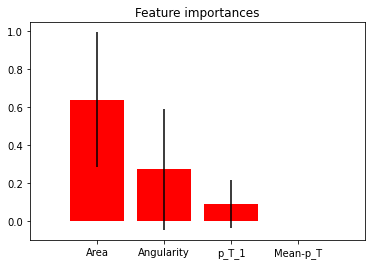

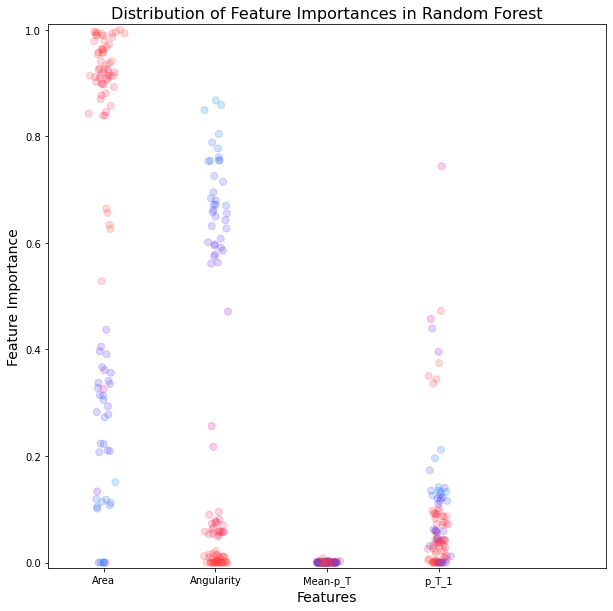

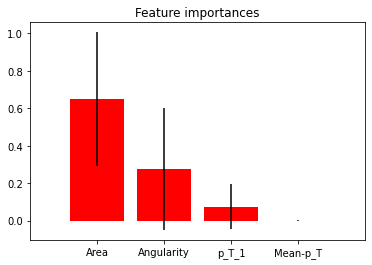

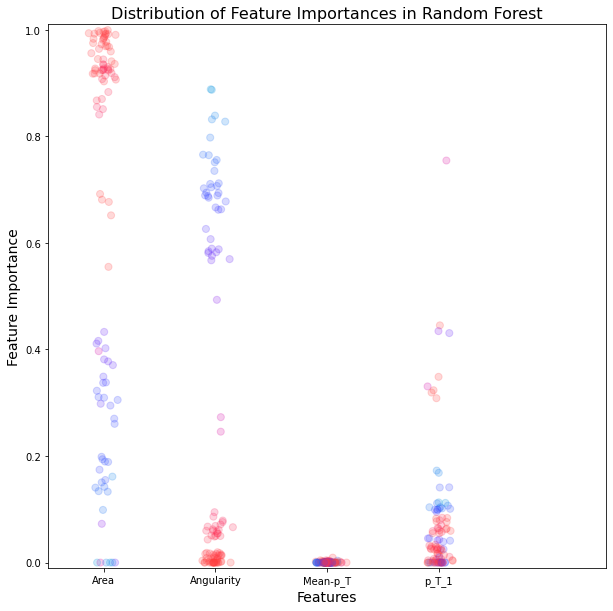

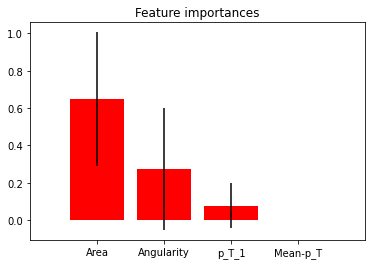

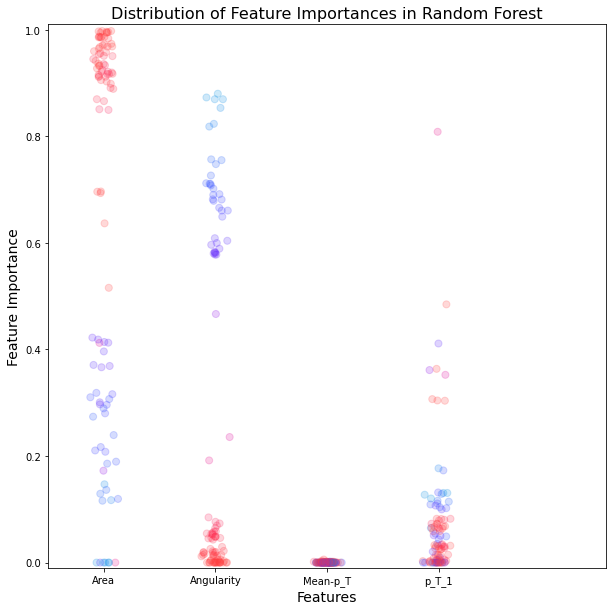

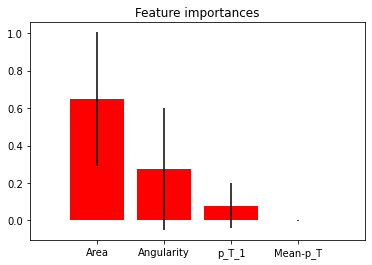

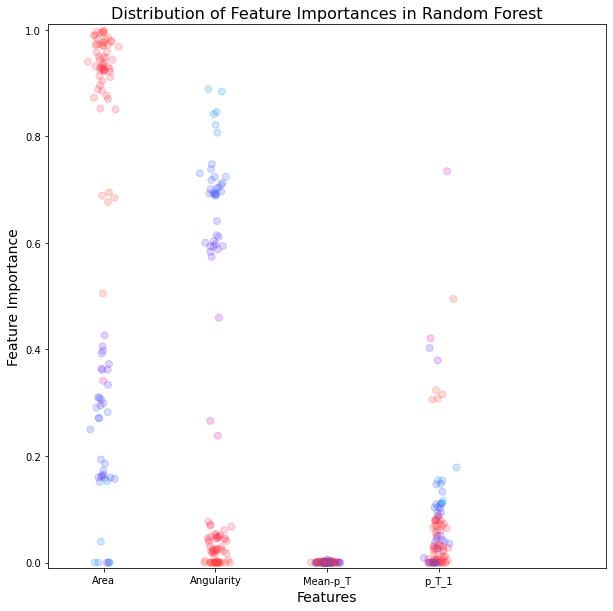

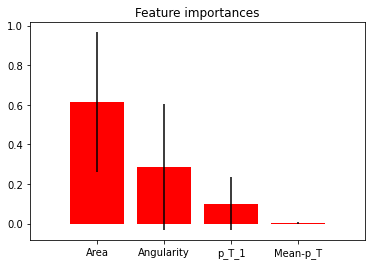

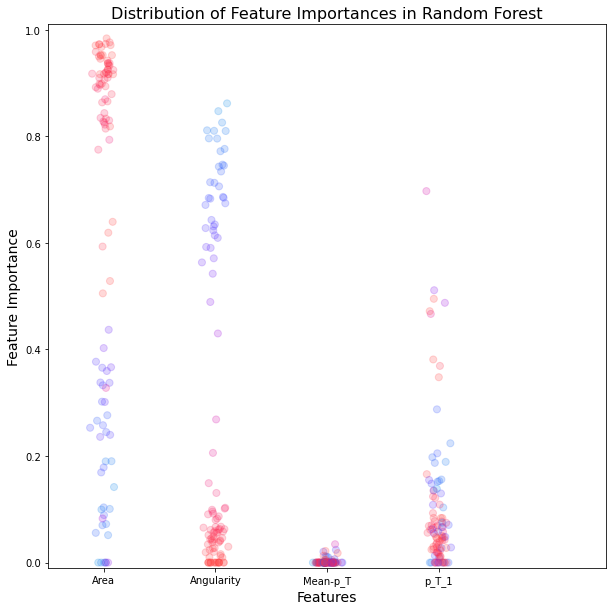

In [88]:
feat_imps = []
model_no=0

ave_perf_metrics = {}

for model in rfModel:
    feat_imp = {}
    perf_metrics = doModelEvaluation(X, Y, Xtest, Ytest, model, rad, ptm, feat_imp,False, model_no)
    
    if model_no==0:
        ave_perf_metrics=perf_metrics
    else:
        for key in ave_perf_metrics.keys():
            ave_perf_metrics[key] = [old+new for old, new in zip(ave_perf_metrics[key], perf_metrics[key])]
    feat_imps.append(feat_imp)
    model_no+=1
ave_perf_metrics = {key:list(map(lambda x:x/(model_no+1), value)) for (key, value) in zip(ave_perf_metrics.keys(),ave_perf_metrics.values())}
print(f"Average Performance Metrics:{ave_perf_metrics}")
text_results[f"R{rad}pt{ptm}"]['ave_perf_metrics'] = ave_perf_metrics
text_results[f"R{rad}pt{ptm}"]['ave_feat_imps'] = feat_imps
print(feat_imps)



In [89]:
if low_pt:
    feat_imps_lowpt = []
    model_no=0
    ave_perf_metrics_low = {}
    for model in rfModelLowpt:
        feat_imp = {}
        perf_metrics_low = doModelEvaluation(XLowpt, YLowpt, XtestLowpt, YtestLowpt, model, rad, ptm, feat_imp, True, model_no)
        if model_no==0:
            ave_perf_metrics_low=perf_metrics_low
        else:
            for key in ave_perf_metrics_low.keys():
                ave_perf_metrics_low[key]+=perf_metrics_low[key]
        feat_imps_lowpt.append(feat_imp)
        model_no+=1
    ave_perf_metrics_low = {key:value/(model_no+1) for (key, value) in zip(ave_perf_metrics_low.keys(), ave_perf_metrics_low.values())}
    print(f"Average Performance Metrics:{ave_perf_metrics_low}")
    text_results[f"R{rad}pt{ptm}"]['ave_perf_metrics_low'] = ave_perf_metrics_low
    text_results[f"R{rad}pt{ptm}"]['feat_imps_low'] = feat_imps_lowpt
    print(feat_imps_lowpt)

In [90]:
# Top cuts and effect
names = X.columns
print([names[x] for x in oracle.tree_.feature])
print(oracle.tree_.threshold)

top_feat = names[oracle.tree_.feature[0]]
top_thresh = oracle.tree_.threshold[0]
print(f"{top_feat} <= {top_thresh}")
key_names = train['Label_Name'].unique()
jet_vals = dict(zip(key_names, oracle.tree_.value[0][0]))
lt_jet_vals = dict(zip(key_names, oracle.tree_.value[oracle.tree_.children_left[0]][0]))
rt_jet_vals = dict(zip(key_names, oracle.tree_.value[oracle.tree_.children_right[0]][0]))



print(f"Vals: {jet_vals}, lt_vals: {lt_jet_vals}, rt_vals: {rt_jet_vals}")
print()

rejection_rates = [100*lt_jet_vals[lbl]/jet_vals[lbl] for lbl in key_names]
retention_rates = [100*rt_jet_vals[lbl]/jet_vals[lbl] for lbl in key_names]

print(f"{rejection_rates=}, {retention_rates=}")

rejection_string = ", ".join([f"{rt:2.1f}% of our {name} jets" for rt, name in zip(rejection_rates, key_names)])
retention_string = ", ".join([f"{rt:2.1f}% of our {name} jets" for rt, name in zip(retention_rates, key_names)])

lt_string = f"{top_feat} <= {top_thresh:2.3f} keeps {rejection_string}"

rt_string = f"{top_feat} > {top_thresh:2.3f} keeps {retention_string}"

print(lt_string)
print()
print(rt_string)


text_results[f"R{rad}pt{ptm}"]["top_cut"] = (top_feat, top_thresh)
text_results[f"R{rad}pt{ptm}"]["top_cut_strings"] = (lt_string, rt_string)

['Area', 'Area', 'p_T_1', 'Mean-p_T', 'Mean-p_T', 'p_T_1', 'Mean-p_T', 'Mean-p_T', 'Angularity', 'Area', 'Mean-p_T', 'Mean-p_T', 'Angularity', 'Mean-p_T', 'Mean-p_T']
[ 0.174909    0.169897    3.1048851  -2.         -2.          2.06246495
 -2.         -2.          0.17108151  0.228033   -2.         -2.
  0.1735465  -2.         -2.        ]
Area <= 0.17490900307893753
Vals: {'Has p_T from Pythia': 582251.0, 'Fake': 830299.0}, lt_vals: {'Has p_T from Pythia': 551565.0, 'Fake': 9503.0}, rt_vals: {'Has p_T from Pythia': 30686.0, 'Fake': 820796.0}

rejection_rates=[94.72976431126781, 1.144527453363186], retention_rates=[5.270235688732179, 98.85547254663682]
Area <= 0.175 keeps 94.7% of our Has p_T from Pythia jets, 1.1% of our Fake jets

Area > 0.175 keeps 5.3% of our Has p_T from Pythia jets, 98.9% of our Fake jets


In [91]:
# Top cuts and effect
if low_pt:
    names = XLowpt.columns
    print([names[x] for x in oracleLowpt.tree_.feature])
    print(oracleLowpt.tree_.threshold)

    top_feat = names[oracleLowpt.tree_.feature[0]]
    top_thresh = oracleLowpt.tree_.threshold[0]
    print(f"{top_feat} <= {top_thresh}")
    key_names = ["Fake", "Squishy", "Real"]
    jet_vals = dict(zip(key_names, oracleLowpt.tree_.value[0][0]))
    lt_jet_vals = dict(zip(key_names, oracleLowpt.tree_.value[oracleLowpt.tree_.children_left[0]][0]))
    rt_jet_vals = dict(zip(key_names, oracleLowpt.tree_.value[oracleLowpt.tree_.children_right[0]][0]))
    print(f"Vals: {jet_vals}, lt_vals: {lt_jet_vals}, rt_vals: {rt_jet_vals}")
    print()

    if len(lt_jet_vals)<3 or len(rt_jet_vals)<3:
        pass
    else:
        fake_jet_rejection_low = 100*lt_jet_vals['Fake']/jet_vals['Fake']
        squishy_jet_rejection_low = 100*lt_jet_vals['Squishy']/jet_vals['Squishy']
        real_jet_rejection_low = 100*lt_jet_vals['Real']/jet_vals['Real']

        fake_jet_retention_low = 100*rt_jet_vals['Fake']/jet_vals['Fake']
        squishy_jet_retention_low = 100*rt_jet_vals['Squishy']/jet_vals['Squishy']
        real_jet_retention_low = 100*rt_jet_vals['Real']/jet_vals['Real']

        lt_string = f"{top_feat} <= {top_thresh:2.3f} keeps {fake_jet_rejection_low:2.2f}% of our Fake jets, {squishy_jet_rejection:2.2f}% of our Squishy jets, and {real_jet_rejection_low:2.2f}% of our Real jets"


        rt_string = f"{top_feat} > {top_thresh:2.3f} keeps {fake_jet_retention_low:2.2f}% of our Fake jets, {squishy_jet_retention_low:2.2f}% of our Squishy jets, and {real_jet_retention_low:2.2f}% of our Real jets"

        print(lt_string)
        print()
        print(rt_string)



        text_results[f"R{rad}pt{ptm}"]["top_cut_strings_low"] = (lt_string, rt_string)

In [92]:
import pprint
import pickle
pp = pprint.PrettyPrinter(depth=6)
pp.pprint(text_results)
if rad==0.6 and ptm==40:
    print("We made it! Let's save the data.")
    pickle.dump(text_results, open("NumericalData.pickle", "wb"))

{'R0.2pt10': {'ave_feat_imps': [{'pthard=10': (Index(['Area', 'Angularity', 'Mean-p_T', 'p_T_1'], dtype='object'),
                                               array([0.68703796, 0.07834103, 0.0186969 , 0.2159241 ]),
                                               array([0.26448092, 0.1215446 , 0.02034502, 0.19423554]),
                                               array([0.87720044, 0.18956343, 0.03085991, 0.36556535]))},
                                {'pthard=10': (Index(['Area', 'Angularity', 'Mean-p_T', 'p_T_1'], dtype='object'),
                                               array([0.69831096, 0.08882764, 0.01103747, 0.20182393]),
                                               array([0.26976182, 0.13360383, 0.01382549, 0.18962276]),
                                               array([0.88795669, 0.19582391, 0.02104324, 0.33746411]))},
                                {'pthard=10': (Index(['Area', 'Angularity', 'Mean-p_T', 'p_T_1'], dtype='object'),
                           

In [60]:
from matplotlib.patches import Rectangle
from matplotlib.text import Annotation

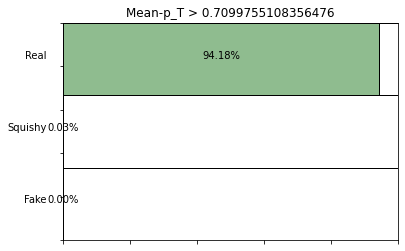

In [41]:
fig, ax = plt.subplots()
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_title(f'{top_feat} > {top_thresh}')

real_h = Rectangle((0, 2/3), real_jet_retention/100, 1/3, facecolor='None', edgecolor='k')
real_bg = Rectangle((0, 2/3), real_jet_retention/100, 1/3, color='darkseagreen')
real_border = Rectangle((0, 2/3), 1, 1/3, edgecolor='k', facecolor='None')

ax.annotate("Real", (-0.05, 4/6), xycoords=('axes fraction', 'figure fraction'), ha='right')
ax.annotate(f"{real_jet_retention:2.2f}%", (real_jet_retention/100/2, 4/6), xycoords=('axes fraction', 'figure fraction'), ha='center')


squishy_h = Rectangle((0, 1/3), squishy_jet_retention/100, 1/3, facecolor='None', edgecolor='k')
squishy_bg = Rectangle((0, 1/3), squishy_jet_retention/100, 1/3, color='coral')
squishy_border = Rectangle((0, 1/3), 1, 1/3, edgecolor='k', facecolor='None')

ax.annotate("Squishy", (-0.05, 2.5/6), xycoords=('axes fraction', 'figure fraction'), ha='right')
ax.annotate(f"{squishy_jet_retention:2.2f}%", (squishy_jet_retention/100/2, 2.5/6), xycoords=('axes fraction', 'figure fraction'), ha='center')

fake_h = Rectangle((0, 0), fake_jet_retention/100, 1/3, facecolor='None', edgecolor='k')
fake_bg = Rectangle((0, 0), fake_jet_retention/100, 1/3, color='powderblue')
fake_border = Rectangle((0, 0), 1, 1/3, edgecolor='k', facecolor='None')

ax.annotate("Fake", (-0.05, 1/6), xycoords=('axes fraction', 'figure fraction'), ha='right')
ax.annotate(f"{fake_jet_retention:2.2f}%", (fake_jet_retention/100/2, 1/6), xycoords=('axes fraction', 'figure fraction'), ha='center')

ax.add_patch(real_bg)
ax.add_patch(real_h)
ax.add_patch(real_border)

ax.add_patch(squishy_bg)
ax.add_patch(squishy_h)
ax.add_patch(squishy_border)

ax.add_patch(fake_bg)
ax.add_patch(fake_h)
ax.add_patch(fake_border)

filename = f'slide_plots/R{rad}pt{ptm}_cut_stats.png'
fig.savefig(filename, dpi=150)


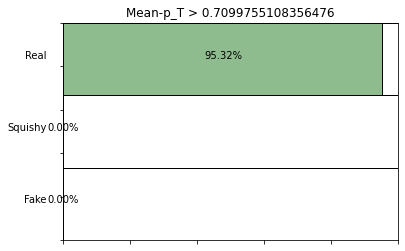

In [42]:
fig, ax = plt.subplots()
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_title(f'{top_feat} > {top_thresh}')

real_h = Rectangle((0, 2/3), real_jet_retention_low/100, 1/3, facecolor='None', edgecolor='k')
real_bg = Rectangle((0, 2/3), real_jet_retention_low/100, 1/3, color='darkseagreen')
real_border = Rectangle((0, 2/3), 1, 1/3, edgecolor='k', facecolor='None')

ax.annotate("Real", (-0.05, 4/6), xycoords=('axes fraction', 'figure fraction'), ha='right')
ax.annotate(f"{real_jet_retention_low:2.2f}%", (real_jet_retention_low/100/2, 4/6), xycoords=('axes fraction', 'figure fraction'), ha='center')


squishy_h = Rectangle((0, 1/3), squishy_jet_retention_low/100, 1/3, facecolor='None', edgecolor='k')
squishy_bg = Rectangle((0, 1/3), squishy_jet_retention_low/100, 1/3, color='coral')
squishy_border = Rectangle((0, 1/3), 1, 1/3, edgecolor='k', facecolor='None')

ax.annotate("Squishy", (-0.05, 2.5/6), xycoords=('axes fraction', 'figure fraction'), ha='right')
ax.annotate(f"{squishy_jet_retention_low:2.2f}%", (squishy_jet_retention_low/100/2, 2.5/6), xycoords=('axes fraction', 'figure fraction'), ha='center')

fake_h = Rectangle((0, 0), fake_jet_retention_low/100, 1/3, facecolor='None', edgecolor='k')
fake_bg = Rectangle((0, 0), fake_jet_retention_low/100, 1/3, color='powderblue')
fake_border = Rectangle((0, 0), 1, 1/3, edgecolor='k', facecolor='None')

ax.annotate("Fake", (-0.05, 1/6), xycoords=('axes fraction', 'figure fraction'), ha='right')
ax.annotate(f"{fake_jet_retention_low:2.2f}%", (fake_jet_retention_low/100/2, 1/6), xycoords=('axes fraction', 'figure fraction'), ha='center')

ax.add_patch(real_bg)
ax.add_patch(real_h)
ax.add_patch(real_border)

ax.add_patch(squishy_bg)
ax.add_patch(squishy_h)
ax.add_patch(squishy_border)

ax.add_patch(fake_bg)
ax.add_patch(fake_h)
ax.add_patch(fake_border)

filename = f'slide_plots/R{rad}pt{ptm}_cut_stats_low.png'
fig.savefig(filename, dpi=150)


[0.00462142 0.0936215  0.40138719 0.50036988]


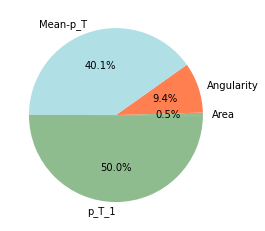

In [43]:
fig, ax = plt.subplots()

sizes = text_results[f"R{rad}pt{ptm}"]['ave_feat_imps'][0][f'pthard={ptm}'][1]
print(sizes)
labels=text_results[f"R{rad}pt{ptm}"]['ave_feat_imps'][0][f'pthard={ptm}'][0]
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['darkseagreen', 'coral', 'powderblue'])
filename = f'slide_plots/R{rad}pt{ptm}_featimp_pie.png'
fig.savefig(filename, dpi=150)


[0.00567088 0.0852604  0.40723793 0.50183079]
<ipython-input-44-21d0248b4814>:6: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['darkseagreen', 'coral', 'powderblue'])


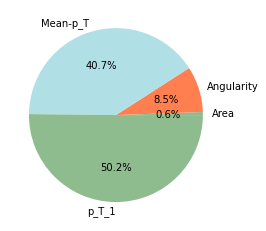

In [44]:
fig, ax = plt.subplots()

sizes = text_results[f"R{rad}pt{ptm}"]['feat_imps_low'][0][f'pthard={ptm}'][1]
print(sizes)
labels=text_results[f"R{rad}pt{ptm}"]['feat_imps_low'][0][f'pthard={ptm}'][0]
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['darkseagreen', 'coral', 'powderblue'])
filename = f'slide_plots/R{rad}pt{ptm}_featimp_pie_low.png'
fig.savefig(filename, dpi=150)